# Sampling basics

We're on a bit of a roll with da basics, so let's do a review/examples of common/simple ideas in sampling real quick:

- Inverse CDF trick
- Rejection sampling
- Importance sampling

We'll also touch on the central limit theorem. We might also come back to Markov chain Monte Carlo later.

In [0]:
# @title Imports

from typing import Union
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotnine as gg
from scipy import stats

gg.theme_set(gg.theme_bw());

## Inverse CDF trick

Say we're given a density $p(x)$ such that its cumulative distribution function $F(x) = \int_{-\infty}^{x}p(x')\mathrm{d}x'$ is invertible.

If we have $z\sim\mathcal{U}(0, 1)$, then by change of variables:

$$
\begin{align}
p(x) &= p(z)\left|\frac{\mathrm{d}z}{\mathrm{d}x}\right| \\
\implies p(x)\mathrm{d}x &= p(z)\mathrm{d}z \\
\implies \underbrace{\int_{-\infty}^x p(x')\mathrm{d}x'}_{F(x)} &= \int_{-\infty}^z p(z')\mathrm{d}z' \\
&= \int_0^z dz' \\
&= z
\end{align}
$$

which implies that $x=F^{-1}(z)$.

### Example
Given a density

$$
f(x) = 
\begin{cases}
\frac{1}{2}\sin(x) & x\in[0,\pi] \\
0 & \mathrm{otherwise}
\end{cases}
$$

So the CDF is 

$$
\begin{align}
F(x) &= \frac{1}{2}\int_{-\infty}^{x}f(x')\mathrm{d}x' \\
&= \frac{1}{2}\int_0^x \sin(x')\mathrm{d}x' \\
&= -\frac{1}{2}\big[\cos(x')\big]_0^x \\
&= \frac{1}{2} - \frac{1}{2}\cos(x)
\end{align}
$$

Inverting this on $[0, \pi]$:

$$
F^{-1}(x) = \cos^{-1}(1-2x)
$$

In [0]:
num_samples = 100000
ys = np.random.rand(num_samples)
xs = np.arccos(1 - 2 * ys)
ps = 0.5 * np.sin(xs)

df = pd.DataFrame({
    'x': xs,
    'p': ps,
})

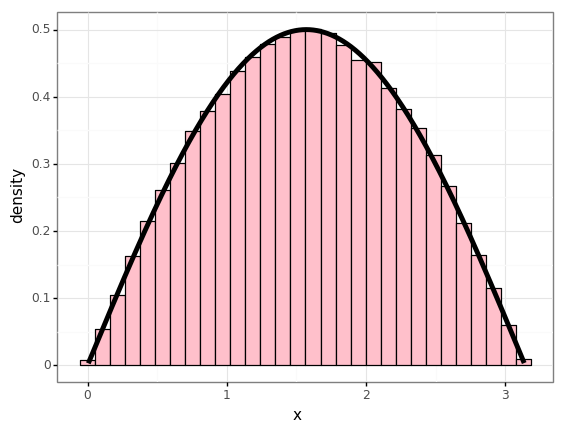

<ggplot: (-9223363288426110555)>

In [401]:
p = (gg.ggplot(df)
     + gg.aes(x='x')
     + gg.geom_histogram(gg.aes(y='stat(density)'), bins=30, color='black', fill='pink')
     + gg.geom_line(gg.aes(y='p'), size=2)
)
p

## Rejection sampling

Say I'm given a pdf $p$, but I can't get its inverse CDF for whatever reason. But, there's another distribution $q$ that I **do** know how to sample from, and I have $kq(x)\geq p(x)$ everywhere in the support of $p$. Then we can use rejection sampling:

1. Draw $x\sim q$.
1. Accept $x$ with probability $\frac{p(x)}{kq(x)}$.

The rejection probability will be

$$
\begin{align}
Pr(\mathrm{accept}) &= \mathbb{E}_{q}\left[\frac{p(x)}{kq(x)}\right] \\
&= \frac{1}{k}\int_{-\infty}^{\infty}p(x)\frac{q(x)}{q(x)}\mathrm{d}x \\
&= \frac{1}{k},
\end{align}
$$

so clearly if we want an efficient sampling procedure we want to pick $q$ such that we don't require $k$ too large.

### Example

Let's consider the density:

$$
p(x) = 
\begin{cases}
\frac{1}{\pi}\sin^2(x) & x\in[0, 2\pi] \\
0 & \mathrm{otherwise}
\end{cases}
$$

Say I know how to sample from the normal distribution $q(x)=\mathcal{N}(\pi, 1)$.

Let's do rejection sampling.

In [0]:
def p(x: Union[float, np.floating, np.ndarray]) -> Union[float, np.ndarray]:
  """Piecewise definition of p(x)=1/pi sin^2(x) for x in [0, 2pi]."""
  lower_bound = 0
  upper_bound = 2 * np.pi
  y = np.sin(x)**2 / np.pi

  if isinstance(x, np.ndarray):
    y[x < 0] = 0.
    y[x > 2*np.pi] = 0.
  elif x < lower_bound or x > upper_bound:
    return 0.

  return y

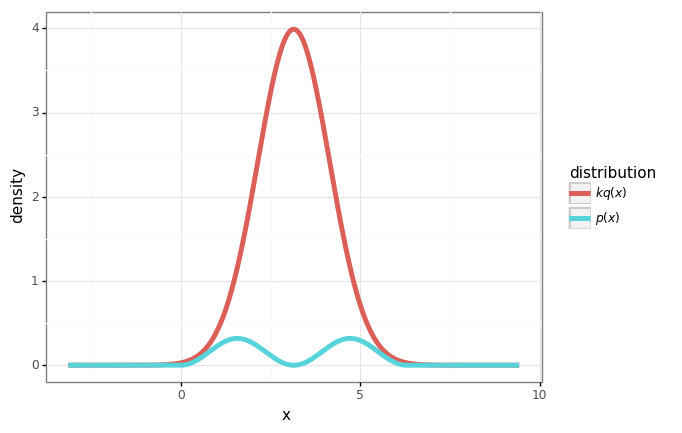

<ggplot: (-9223363288426236556)>

In [403]:
# Define q, the distribution we can sample from.
normal = stats.distributions.norm(loc=np.pi)
q = normal.pdf

# Set k=10 (we'll see that this is *just* enough).
k = 10

# Plot these distributions
xs = np.linspace(-np.pi, 3*np.pi, 1000)
qs = k * q(xs)
ps = p(xs)

df = pd.DataFrame({
    r'$p(x)$': ps,
    r'$kq(x)$': qs,
    'x': xs
})

df = pd.melt(df, id_vars=['x'], var_name='distribution', value_name='density')

plot = (gg.ggplot(df)
        + gg.aes(x='x', y='density', color='distribution') 
        + gg.geom_line(size=2)
)
plot

In [404]:
# Do rejection sampling.
num_samples = 10000

samples = normal.rvs(size=num_samples)
ratios = p(samples) / (k * q(samples))
accept = np.random.rand(num_samples) < ratios
accepted_samples = samples[accept]

print('Acceptance rate:', len(accepted_samples) / num_samples, '(k={}).'.format(k))

Acceptance rate: 0.0981 (k=10).


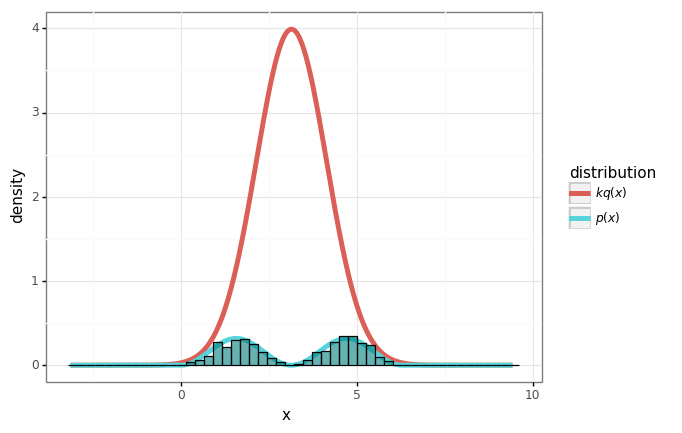

<ggplot: (-9223363288423618367)>

In [405]:
samples_df = pd.DataFrame({'x': accepted_samples})
plot + gg.geom_histogram(data=samples_df, mapping=gg.aes(x='x', y='stat(density)', inherit_aes=False), 
                         bins=50, color='black', fill='teal', alpha=0.6)

## Importance sampling

Often we don't care so much about drawing samples from some distribution $p$ but rather to compute expectations of things. This motivates **importance sampling**:

$$
\begin{align}
\mathbb{E}_p[f] &= \int f(x) p(x) \mathrm{d} x \\
&= \int f(x) \frac{p(x)}{q(x)} q(x) \mathrm{d} x \\
&= \mathbb{E}_q\left[ f(x) \frac{p(x)}{q(x)} \right].
\end{align}
$$

This allows us to generate Monte-Carlo estimates of $f$ w.r.t. $p$ by drawing samples from a completely different distribution $q$.

### Example

In this example, we'll use samples from the exponential distribution  $q(x) = e^{-x}$ to compute the mean of the beta distribution $\beta(2, 2)$.

In [0]:
p = stats.distributions.beta(a=2, b=4)
q = stats.distributions.expon()

xs = np.linspace(0, 5, num=1000)
ps = p.pdf(xs)
qs = q.pdf(xs)

df = pd.DataFrame({
    'x': xs,
    'p': ps,
    'q': qs,
})

df = pd.melt(df, id_vars=['x'], var_name='distribution', value_name='density')

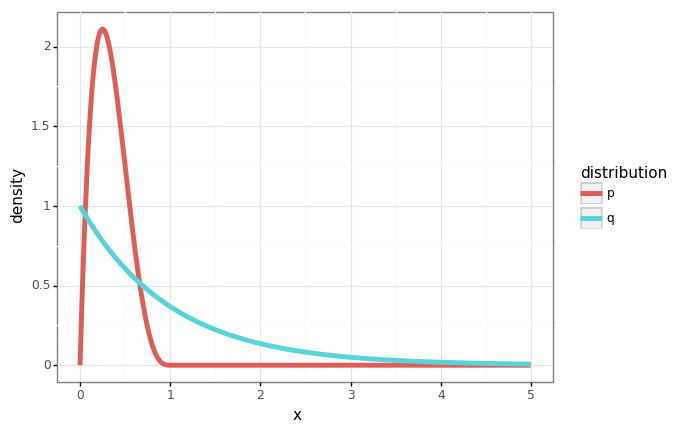

<ggplot: (-9223363288426317985)>

In [423]:
gg.ggplot(df) + gg.aes(x='x', y='density', color='distribution') + gg.geom_line(size=2)

In [424]:
num_samples = 10000
samples = q.rvs(size=num_samples)
mean = np.mean(samples * p.pdf(samples) / q.pdf(samples))

print('Importance weighted estimate: {mean:.4f}. True mean: {true_mean:.4f}.'.format(mean=mean, true_mean=p.mean()))

Importance weighted estimate: 0.3357. True mean: 0.3333.


## Central limit theorem

Say we draw a dataset of $N$ samples i.i.d. from some finite-variance distribution $p(x)$:

$$
\mathcal{D} = \left\{x^{(1)},\ x^{(2)}, \dots, x^{(N)}\right\}
$$

The central limit theorem (CLT) states that the sample mean

$$
\hat{\mu} = \frac{1}{N}\sum_{n=1}^N x^{(n)}
$$

is a normally-distributed random variable:

$$
\hat{\mu} \sim \mathcal{N}\left(\mathbb{E}[X], \frac{\mathrm{Var}[X]}{N}\right)
$$

Note that this holds regardless of $p$ -- an astonishing result.

### Example

To demonstrate this we'll draw a bunch of different datasets (trials) $\mathcal{D}$ from an exponential distribution and compute the statistics of the sample mean, and compare them to the distribution we expect from the CLT.

In [0]:
# Empirically compute a histogram of the sample mean for various trials.

num_samples = 100  # Size of D.
num_trials = 1000

p = stats.distributions.expon()
results = []
for _ in range(num_trials):
  result = p.rvs(size=num_samples).mean()
  results.append(result)

df = pd.DataFrame({
    r'$\mu$': np.array(results)
})

In [0]:
# CLT says we should expect the sample mean to follow this distribution.
normal = stats.distributions.norm(loc=p.mean(), scale=np.sqrt(p.var() / num_samples))
xs = np.linspace(0.6, 1.4, num=1000)

p_df = pd.DataFrame({
  'x': xs,
  'p': normal.pdf(xs)
})

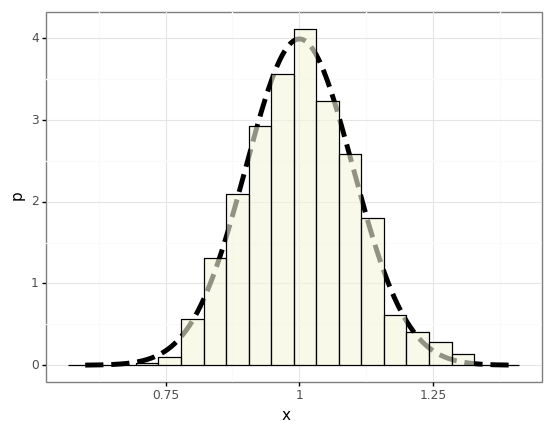

<ggplot: (-9223363288423460783)>

In [418]:
plot = (gg.ggplot(df)
        + gg.geom_line(data=p_df, mapping=gg.aes(x='x', y='p'), size=2, linetype='dashed')
        + gg.geom_histogram(mapping=gg.aes(x='$\mu$', y='stat(density)'), bins=20, colour='black', fill='beige', alpha=0.6)
)
plot